In [1]:
import chardet
import pandas as pd
import numpy as np
import pickle
import os
import json
import matplotlib.pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### GET DATA

In [3]:
# look at the first ten thousand bytes to guess the character encoding
with open('./all-data.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [4]:
df = pd.read_csv('./all-data.csv', header=None, sep=",", encoding='ISO-8859-1')

In [5]:
df.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [6]:
X, y_ = df[1].to_numpy(), df[0].to_numpy()
X.shape

(4846,)

In [7]:
np.unique(y_)

array(['negative', 'neutral', 'positive'], dtype=object)

In [8]:
y = pd.get_dummies(y_)
print(y)
y = y.to_numpy()

      negative  neutral  positive
0            0        1         0
1            0        1         0
2            1        0         0
3            0        0         1
4            0        0         1
...        ...      ...       ...
4841         1        0         0
4842         0        1         0
4843         1        0         0
4844         1        0         0
4845         1        0         0

[4846 rows x 3 columns]


### ESTABLISHING A BASELINE

### Most frequent class in y

In [9]:
"Baseline for random guessing = %.2f%%" % (np.unique(y_, return_counts=True)[1].max() / len(y)*100)

'Baseline for random guessing = 59.41%'

## Using already existing sentiment regressor from Algorithmia

#### Get a sentiment [-1, +1] from Algorithmia and use a decision tree for classification then
https://algorithmia.com/algorithms/nlp/SentimentAnalysis

In [10]:
# import Algorithmia

# input = {
#   "document": "I really like Algorithmia!"
# }
# client = Algorithmia.client('sim1DmSFr2RBDovXpR+AfDip0iW1')
# algo = client.algo('nlp/SentimentAnalysis/1.0.5')
# algo.set_options(timeout=300) # optional
# print(algo.pipe(input).result)

In [11]:
def get_sentiment(X):
    print("API CALLING ...")
    resp = algo.pipe([{"document": x, "language": "auto"} for x in X]).result
    return resp

In [12]:
test_len = len(X) # how many samples should be analyzed
algorithmia_results_loc = f"intermediate_results/algorithmia_{test_len:04d}.pkl"

if os.path.exists(algorithmia_results_loc):
    with open(algorithmia_results_loc, "rb") as f:
        algorithmia_results = pickle.load(f)
    print("LOADED RESULTS")
else:
    algorithmia_results = get_sentiment(X[:test_len])
    with open(algorithmia_results_loc, "wb") as f:
        print("SAVING RESULTS ...", end="\r")
        pickle.dump(algorithmia_results, f)
    print("SAVED RESULTS \t\t\t")

LOADED RESULTS


##### Check that all docs are assigned the right sentiment

In [13]:
assert np.mean([algorithmia_results[i]['document'] == x for i, x in enumerate(X[:test_len])]) == 1

#### Run logRegression now

In [14]:
X_algorithmia = np.array([e['sentiment'] for e in algorithmia_results]).reshape(-1,1)
y_algorithmia = np.argmax(y[:test_len],axis=1)

In [15]:
X_algorithmia_train, X_algorithmia_test, y_algorithmia_train, y_algorithmia_test = train_test_split(X_algorithmia, y_algorithmia, test_size=0.33, random_state=42)

In [16]:
model = DecisionTreeClassifier()
model.fit(X_algorithmia_train,y_algorithmia_train)
"Baseline for classifying Algorithmia sentiment = %.2f%%" % (model.score(X_algorithmia_test,y_algorithmia_test)*100)

'Baseline for classifying Algorithmia sentiment = 61.81%'

In [17]:
np.unique(model.predict(X_algorithmia), return_counts=True), np.unique(y_algorithmia, return_counts=True)

((array([0, 1, 2]), array([ 344, 3642,  860])),
 (array([0, 1, 2]), array([ 604, 2879, 1363])))

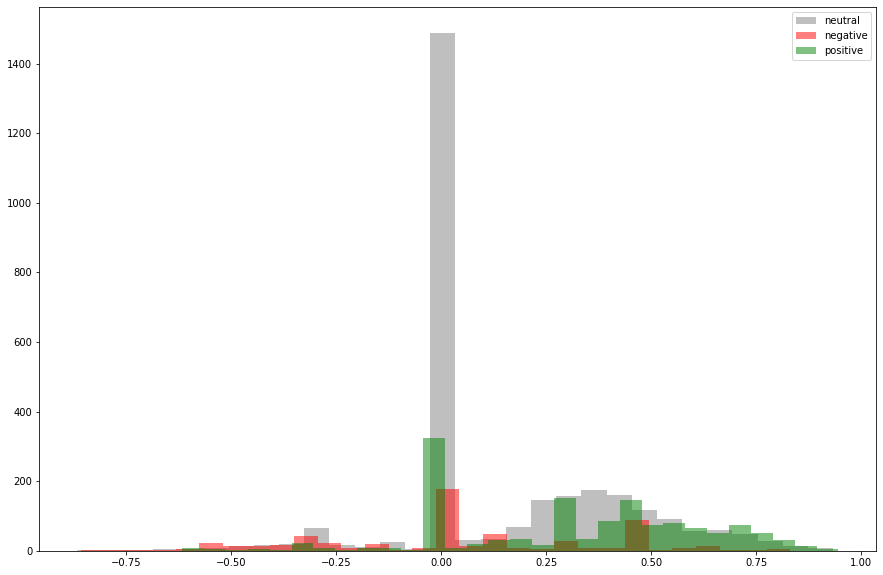

In [18]:
# Can somehow distinguish between positive and negative, but not very good
plt.figure(figsize=(15,10))
plt.hist(X_algorithmia[y_algorithmia==1], color="gray", alpha=0.5,label="neutral", bins=30)
plt.hist(X_algorithmia[y_algorithmia==0], color="red", alpha=0.5,label="negative", bins=30)
plt.hist(X_algorithmia[y_algorithmia==2], color="green", alpha=0.5,label="positive", bins=30)
plt.legend()
plt.show()